In [246]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25,30)

In [121]:
lyrics = pd.read_csv("./FinalTaylorSwiftLyrics.csv")

In [122]:
lyrics.isnull().sum()

album          0
track_title    0
lyric          1
year           0
dtype: int64

In [123]:
lyrics.dropna(axis=0,inplace=True)
lyrics.reset_index(inplace=True,drop=True)
lyrics['words'] = lyrics['lyric'].apply(lambda x: x.split())

In [124]:
lyrics.head()

,album,track_title,lyric,year,words
0,Taylor Swift,Tim McGraw,He said the way my blue eyes shined,2006,"[He, said, the, way, my, blue, eyes, shined]"
1,Taylor Swift,Tim McGraw,Put those Georgia stars to shame that night,2006,"[Put, those, Georgia, stars, to, shame, that, ..."
2,Taylor Swift,Tim McGraw,"I said, ""That's a lie""",2006,"[I, said,, ""That's, a, lie""]"
3,Taylor Swift,Tim McGraw,Just a boy in a Chevy truck,2006,"[Just, a, boy, in, a, Chevy, truck]"
4,Taylor Swift,Tim McGraw,That had a tendency of gettin' stuck,2006,"[That, had, a, tendency, of, gettin', stuck]"


### Extracting Audio Features From Spotify

In [125]:
import spotipy
import json

with open('./secret.json','r') as f:
    secret = json.load(f)

In [126]:
client_id =secret['client_id']
client_secret = secret['client_secret']
username = secret['username']
redirect_uri="http://localhost:7777/callback"
scope = "user-library-read"

In [127]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

#sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, username=username))
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=client_id,client_secret=client_secret))

In [128]:
track_titles =[]
track_albums=[]
alb_track ={}
for track in lyrics['track_title'].unique():
    index_first = list(lyrics['track_title']).index(track)
    track_titles.append(track)
    track_albums.append(lyrics['album'][index_first])

alb_track['Albums'] = track_albums
alb_track['Tracks'] = track_titles
df_albums = pd.DataFrame (alb_track)
df_albums.head()

,Albums,Tracks
0,Taylor Swift,Tim McGraw
1,Taylor Swift,Picture To Burn
2,Taylor Swift,Teardrops On My Guitar
3,Taylor Swift,A Place In This World
4,Taylor Swift,Cold as You


In [129]:
artist_list =[]
for index,track in enumerate(df_albums['Tracks']):
    if "(Ft." in track:
        #print(track)
        new_trackname = track.split("(Ft.",1)[0].strip()
        df_albums['Tracks'][index] = new_trackname
        ft_artist=(((track.split("(Ft.",1)[1]).split(")")[0]).strip())
        if '&' in ft_artist:
            mul_artist= ft_artist.split("&")
            mul_artist = [name.strip() for name in mul_artist]
            ft_artist = ", ".join(mul_artist)
            
        artist_tag = "Taylor Swift, "+ft_artist
        #print(artist_tag)
    
    else:
        artist_tag ="Taylor Swift"
    artist_list.append(artist_tag)
        
df_albums['Artist'] = artist_list

In [130]:
index_1 =list(df_albums['Tracks']).index("You're Not Sorry")
df_albums['Tracks'][index_1] = "Youre Not Sorry"

In [131]:
import timeit
start_time = timeit.default_timer()

track_list=[]
for artist,album,track in zip(df_albums['Artist'],df_albums['Albums'],df_albums['Tracks']):
    alb_track={}
    query = 'artist:{} track:{} album:{}'.format(artist, track, album)
    track_search = sp.search(q=query)
    
    #with open("./SearchData.json","w") as f:
        #json.dump(track_search,f)
    
    try:
        track_uri = (track_search['tracks']['items'][0]['uri'])
        trackid = (track_search['tracks']['items'][0]['id'])
        audio_fts = sp.audio_features(tracks=[trackid])
    
    except:
        track_uri =""
        trackid =""
        audio_fts=[" "]
        print(track)
        pass
    
    alb_track['Album'] = album
    alb_track['Artist'] = artist
    alb_track['Track'] = track
    alb_track['TrackURI'] = track_uri
    alb_track['TrackID'] = trackid
    
    #audio_ans = sp.audio_analysis(trackid)
    
    #print(type(audio_fts),type(audio_ans))
    #with open("./AudioFeatures.json","w") as f:
        #print(audio_fts[0])
        #json.dump(audio_fts[0],f)
    
    alb_track['AudioFeatures'] = audio_fts[0]
    track_list.append(alb_track)

elapsed = timeit.default_timer() - start_time

In [132]:
elapsed

42.29677149999952

#### Post Processing and Exporting

In [141]:
df_complete = pd.DataFrame(track_list)
df_complete.loc[22,:]
#df_complete.to_csv("./Saved Data/CompleteTaylorSwiftFeatures.csv",index=False)

In [145]:
df_audio = pd.DataFrame(list(df_complete['AudioFeatures']))
df_audio.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [151]:
df_audio.drop(columns=['type','id','uri','track_href','analysis_url'])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.580,0.491,0,-6.462,1,0.0251,0.57500,0.000000,0.1210,0.425,76.009,232107,4
1,0.658,0.877,7,-2.098,1,0.0323,0.17300,0.000000,0.0962,0.821,105.586,173067,4
2,0.621,0.417,10,-6.941,1,0.0231,0.28800,0.000000,0.1190,0.289,99.953,203040,4
3,0.576,0.777,9,-2.881,1,0.0324,0.05100,0.000000,0.3200,0.428,115.028,199200,4
4,0.418,0.482,5,-5.769,1,0.0266,0.21700,0.000000,0.1230,0.261,175.558,239013,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.662,0.747,11,-6.926,0,0.0736,0.02800,0.006150,0.1380,0.487,150.088,234147,4
107,0.811,0.719,9,-6.553,1,0.0497,0.01290,0.000014,0.0742,0.865,103.979,222400,4
108,0.433,0.182,0,-12.566,1,0.0641,0.90700,0.000000,0.1230,0.421,207.476,201587,4
109,0.292,0.574,0,-9.375,1,0.0401,0.12000,0.005690,0.0663,0.166,124.344,211240,4


In [162]:
final_features = pd.concat((df_complete.drop(columns=['AudioFeatures']),df_audio.drop(columns=['type','id','uri','track_href','analysis_url'])), axis=1)
final_features.columns

Index(['Album', 'Artist', 'Track', 'TrackURI', 'TrackID', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')

In [163]:
final_features=final_features[['Album', 'Artist', 'Track', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature','TrackURI', 'TrackID']]

In [199]:
final_features.drop(columns=["Lyrics"]).to_csv("./Saved Data/TaylorSwiftFeatureSet.csv",index=False)

### Lyrics Analyses

#### Data Preprocessing

In [165]:
df_albums = lyrics
artist_list =[]
for index,track in enumerate(df_albums['track_title']):
    if "(Ft." in track:
        #print(track)
        new_trackname = track.split("(Ft.",1)[0].strip()
        df_albums['track_title'][index] = new_trackname
        ft_artist=(((track.split("(Ft.",1)[1]).split(")")[0]).strip())
        if '&' in ft_artist:
            mul_artist= ft_artist.split("&")
            mul_artist = [name.strip() for name in mul_artist]
            ft_artist = ", ".join(mul_artist)
            
        artist_tag = "Taylor Swift, "+ft_artist
        #print(artist_tag)
    
    else:
        artist_tag ="Taylor Swift"
    artist_list.append(artist_tag)
        
df_albums['artist'] = artist_list

C:\Users\ishaa\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [175]:
df_albums=df_albums[['album','year','artist','track_title','lyric','words']]
df_albums

,album,year,artist,track_title,lyric,words
0,Taylor Swift,2006,Taylor Swift,Tim McGraw,He said the way my blue eyes shined,"[He, said, the, way, my, blue, eyes, shined]"
1,Taylor Swift,2006,Taylor Swift,Tim McGraw,Put those Georgia stars to shame that night,"[Put, those, Georgia, stars, to, shame, that, ..."
2,Taylor Swift,2006,Taylor Swift,Tim McGraw,"I said, ""That's a lie""","[I, said,, ""That's, a, lie""]"
3,Taylor Swift,2006,Taylor Swift,Tim McGraw,Just a boy in a Chevy truck,"[Just, a, boy, in, a, Chevy, truck]"
4,Taylor Swift,2006,Taylor Swift,Tim McGraw,That had a tendency of gettin' stuck,"[That, had, a, tendency, of, gettin', stuck]"
...,...,...,...,...,...,...
5458,Lover,2020,Taylor Swift,You Need to Calm Down,"Oh-oh, oh-oh, oh-oh, oh-oh, oh-oh!","[Oh-oh,, oh-oh,, oh-oh,, oh-oh,, oh-oh!]"
5459,Lover,2020,Taylor Swift,You Need to Calm Down,(You need to calm down),"[(You, need, to, calm, down)]"
5460,Lover,2020,Taylor Swift,You Need to Calm Down,(You're being too loud),"[(You're, being, too, loud)]"
5461,Lover,2020,Taylor Swift,You Need to Calm Down,(Can you stop?),"[(Can, you, stop?)]"


In [229]:
lyriclist=[]
for i,track in enumerate(df_albums['track_title'].unique()):
    lyrics = "\n".join(list(df_albums.loc[df_albums['track_title'] == track,'lyric']))
    lyriclist.append(lyrics)

In [230]:
final_features['Lyrics'] = lyriclist

In [231]:
final_features.to_csv("./Saved Data/TaylorSwiftLyricsFeatureSet.csv",index=False)

In [233]:
final_features.head(1)

,Album,Artist,Track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,TrackURI,TrackID,Lyrics
0,Taylor Swift,Taylor Swift,Tim McGraw,0.58,0.491,0,-6.462,1,0.0251,0.575,0.0,0.121,0.425,76.009,232107,4,spotify:track:0Om9WAB5RS09L80DyOfTNa,0Om9WAB5RS09L80DyOfTNa,He said the way my blue eyes shined\nPut those...


#### Sentiment Analysis

In [234]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ishaa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [240]:
df_sentiment = pd.DataFrame(columns=('track', 'pos', 'neu', 'neg'))
sid = SentimentIntensityAnalyzer()
i=0

start_time = timeit.default_timer()
for lyrics,track in zip(final_features['Lyrics'],final_features['Track']):
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    
    for sentence in lyrics.split("\n"):
        #this_sentence = sentence.decode("utf-8")
        comp = sid.polarity_scores(sentence)
        
        comp = comp['compound']
        if comp >= 0.5:
            num_positive += 1
        
        elif comp > -0.5 and comp < 0.5:
            num_neutral += 1
        
        else:
            num_negative += 1
    
    num_total = num_negative + num_neutral + num_positive
    percent_negative = (num_negative/float(num_total))*100
    percent_neutral = (num_neutral/float(num_total))*100
    percent_positive = (num_positive/float(num_total))*100
    
    df_sentiment.loc[i] = (track, percent_positive, percent_neutral, percent_negative)
    i+=1

elapsed = timeit.default_timer() - start_time

In [241]:
elapsed

0.6989261000016995

#### Plot for Lyric Sentiments

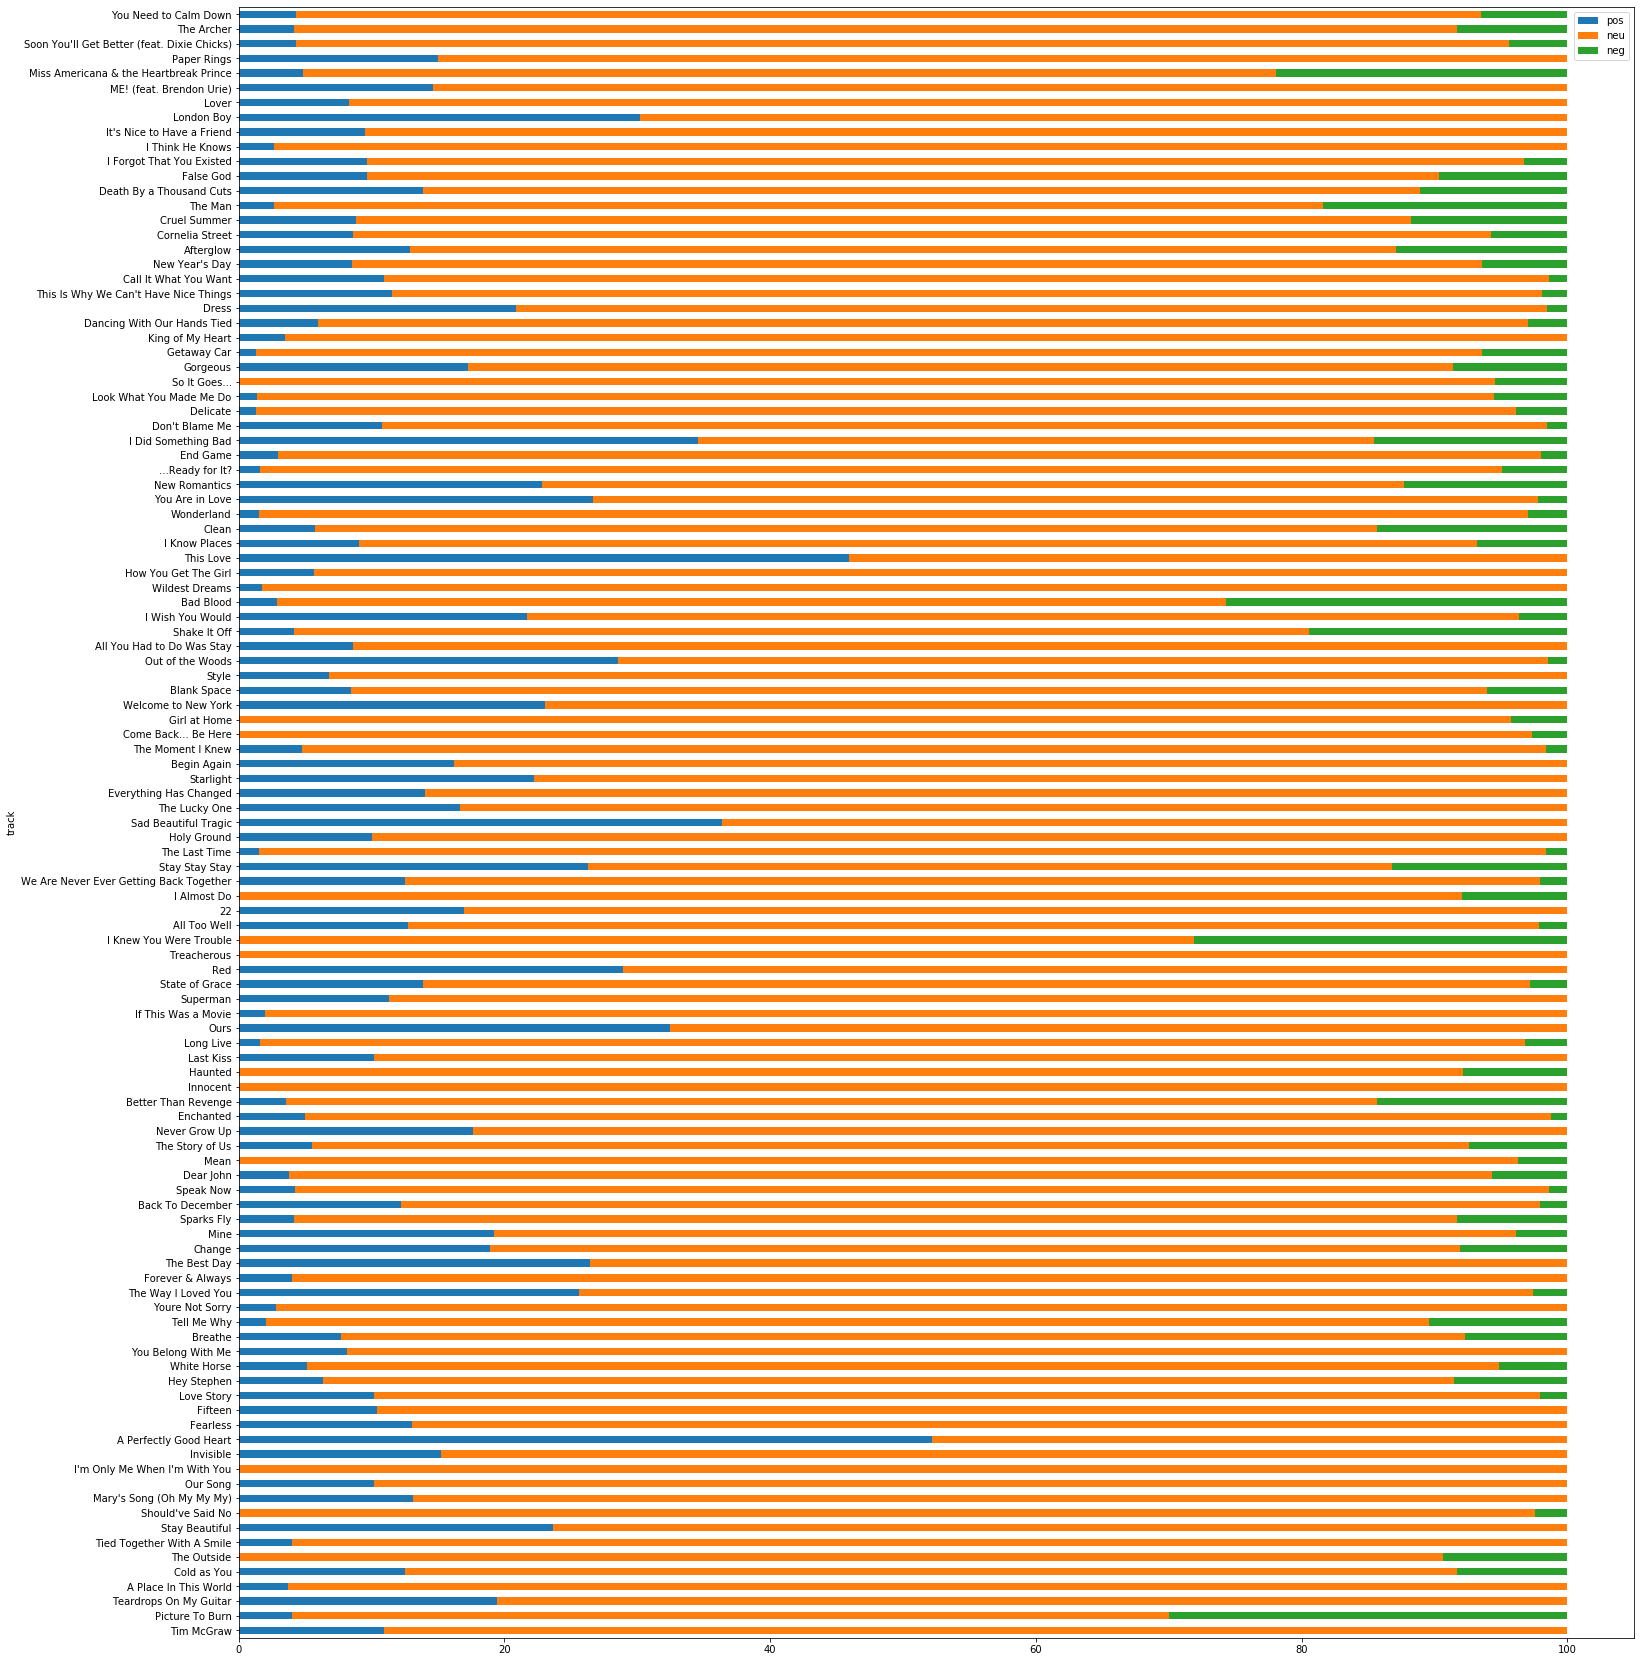

In [251]:
df_sentiment.plot(kind="barh", x='track', stacked=True)
plt.savefig('./Plots/SentimentOfLyrics')

#### Other Analyses

In [248]:
df_sentiment

,track,pos,neu,neg
0,Tim McGraw,10.909091,89.090909,0.000000
1,Picture To Burn,4.000000,66.000000,30.000000
2,Teardrops On My Guitar,19.444444,80.555556,0.000000
3,A Place In This World,3.703704,96.296296,0.000000
4,Cold as You,12.500000,79.166667,8.333333
...,...,...,...,...
106,Miss Americana & the Heartbreak Prince,4.878049,73.170732,21.951220
107,Paper Rings,15.000000,85.000000,0.000000
108,Soon You'll Get Better (feat. Dixie Chicks),4.347826,91.304348,4.347826
109,The Archer,4.166667,87.500000,8.333333
